<a href="https://colab.research.google.com/github/wch18735/AI_and_ASP/blob/master/2.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'<<{_str}>>:')
        _str = ''
    if type(var)!=type([]):
        try: 
            print(f'Shape:{var.shape}')
        except : 
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

# modify test 

# Model 설계 workfolw

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data 
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.__version__,pl.__version__,

('1.12.0+cu113', '1.6.5')

## 1. 첫번째 모델 만들기

### Dataset 준비

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def dataLoader(batch_size=128):
    train_dataset = MNIST('', transform=transforms.ToTensor(), train=True, download=True)
    test_dataset = MNIST('', transform=transforms.ToTensor(), train=False, download=True)
    trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return (trainDataLoader,valDataLoader)

trainDataLoader,valDataLoader = dataLoader()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



###  Model 정의

In [ ]:
loss_function = nn.CrossEntropyLoss()
class FirstModel(pl.LightningModule):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10) )
    def forward(self, x):
        out = self.layers(x)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        self.log_dict({'loss':loss, 'acc':acc})
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        self.log_dict({'val_loss':loss, 'val_acc':acc})
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

* Model 생성, Summary보기 

In [ ]:
model = FirstModel()
summary(model, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FirstModel                               [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Flatten: 2-1                      [128, 784]                --
│    └─Linear: 2-2                       [128, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 1.00
Input size (MB): 0.40
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.44

### Training, History logging 

In [ ]:
%%time
epochs = 1
logger = pl.loggers.CSVLogger("logs", name="firstModel")
trainer = pl.Trainer(max_epochs=epochs, logger=logger, accelerator="auto")
trainer.fit(model, trainDataLoader, valDataLoader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/firstModel
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 7.9 K 
--------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

CPU times: user 12.6 s, sys: 78.3 ms, total: 12.7 s
Wall time: 18.1 s


* Log data 보기 

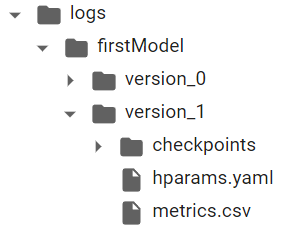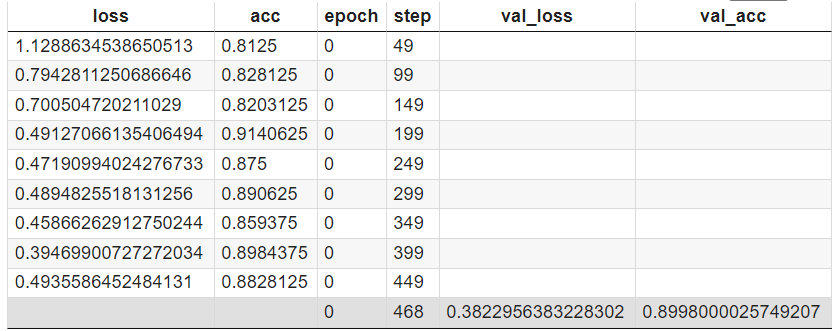

### Test 

In [ ]:
test_batch = next(iter(valDataLoader))  #(128,1,28,28),(128,10) <- 
preds = model(test_batch[0])            #(128,10) <- ((128,1,28,28),(128,))
p(preds[0],'preds'),print()                     # Class logits (10,)
p(torch.softmax(preds[0],dim=0),'softmax'),print()# Class Prob.  (10,) 
p(np.argmax(torch.softmax(preds[0],dim=0).detach()),'index') # Class idx 

<<preds>>:
Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([-1.4628, -5.3119, -1.5017,  0.5638, -2.2109, -1.6166, -4.2610,  6.0640,
        -1.4446,  1.2532], grad_fn=<SelectBackward0>)

<<softmax>>:
Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([5.3073e-04, 1.1304e-05, 5.1046e-04, 4.0272e-03, 2.5118e-04, 4.5505e-04,
        3.2331e-05, 9.8562e-01, 5.4048e-04, 8.0244e-03],
       grad_fn=<SoftmaxBackward0>)

<<index>>:
Shape:torch.Size([])
Type: <class 'torch.Tensor'>
Values: 7


* History file read

In [ ]:
v_num = model.get_progress_bar_dict()['v_num']

history = pd.read_csv(f'./logs/firstModel/version_{v_num}/metrics.csv')
history.groupby('epoch').mean().drop('step', axis=1)

,loss,acc,val_loss,val_acc
epoch,,,,
0,0.630902,0.855903,0.378312,0.904


In [ ]:
history

,loss,acc,epoch,step,val_loss,val_acc
0,1.044168,0.835938,0,49,NaN,NaN
1,0.886060,0.781250,0,99,NaN,NaN
2,0.675356,0.835938,0,149,NaN,NaN
3,0.515605,0.898438,0,199,NaN,NaN
4,0.553713,0.875000,0,249,NaN,NaN
5,0.522607,0.835938,0,299,NaN,NaN
6,0.531471,0.851562,0,349,NaN,NaN
7,0.470892,0.890625,0,399,NaN,NaN
8,0.478248,0.898438,0,449,NaN,NaN
9,NaN,NaN,0,468,0.378312,0.904


## 2. 모듈을 만드는 방법

### 1 Module container 사용 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(5, 10)
        self.linear2 = nn.Linear(10,1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

model = Model()
summary(model, input_size=(8, 5))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1]                    --
├─Linear: 1-1                            [8, 10]                   60
├─Linear: 1-2                            [8, 1]                    11
Total params: 71
Trainable params: 71
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

**+ class** 

In [ ]:
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
model = MyModel()
summary(model, input_size=(8, 5))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [8, 1]                    --
├─Model: 1-1                             [8, 1]                    --
│    └─Linear: 2-1                       [8, 10]                   60
│    └─Linear: 2-2                       [8, 1]                    11
Total params: 71
Trainable params: 71
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
p(model,'model')
p(model.layers,'model.layers')
p(model.layers.linear1,'model.layers.linear1'),print()
p(model.layers.children,'model.layers.children')

<<model>>:
Type: <class '__main__.MyModel'>
Values: MyModel(
  (layers): Model(
    (linear1): Linear(in_features=5, out_features=10, bias=True)
    (linear2): Linear(in_features=10, out_features=1, bias=True)
  )
)
<<model.layers>>:
Type: <class '__main__.Model'>
Values: Model(
  (linear1): Linear(in_features=5, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)
<<model.layers.linear1>>:
Type: <class 'torch.nn.modules.linear.Linear'>
Values: Linear(in_features=5, out_features=10, bias=True)

<<model.layers.children>>:
Type: <class 'method'>
Values: <bound method Module.children of Model(
  (linear1): Linear(in_features=5, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)>


### 2.1 Sequential container : Type 1

 - argument로 module을 전달



In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.Linear(64,10) 
            )  
    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 64]                   50,240
│    └─Linear: 2-3                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

### 2.2 Sequential + add_module(): Type 2

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential()
        self.layers.add_module('linear1', nn.Linear(28*28, 64))
        self.layers.add_module('linear2', nn.Linear(64,10))
    
    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 1, 28*28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1, 10]                --
├─Sequential: 1-1                        [8, 1, 10]                --
│    └─Linear: 2-1                       [8, 1, 64]                50,240
│    └─Linear: 2-2                       [8, 1, 10]                650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

### 2.3 Sequential + OrderedDict : Type 3

In [ ]:
from collections import OrderedDict
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(OrderedDict([
            ('flatten', nn.Flatten()),
            ('linear1', nn.Linear(28*28,64)),
            ('linear2', nn.Linear(64,10)),
          ]))
    def forward(self, x):
        out = self.layers(x)
        return out

model = Model()
summary(model, input_size=(8, 1, 28, 28))      

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 64]                   50,240
│    └─Linear: 2-3                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

### 3 ModuleList

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(5)])

    def forward(self, x):
        # ModuleList can act as an iterable, or be indexed using ints
        for i, l in enumerate(self.linears):
            x = self.linears[i // 2](x) + l(x)  
        return x
    #0: x = l[0](x)+l[0](x)
    #1: x = l[0](x)+l[1](x)
    #2: x = l[1](x)+l[2](x)
    #3: x = l[1](x)+l[3](x)
    #4: x = l[2](x)+l[4](x)

model = Model()
summary(model, input_size=(8, 1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 1, 10]                --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [8, 1, 10]                110
│    └─Linear: 2-2                       [8, 1, 10]                (recursive)
│    └─Linear: 2-3                       [8, 1, 10]                (recursive)
│    └─Linear: 2-4                       [8, 1, 10]                110
│    └─Linear: 2-5                       [8, 1, 10]                (recursive)
│    └─Linear: 2-6                       [8, 1, 10]                110
│    └─Linear: 2-7                       [8, 1, 10]                (recursive)
│    └─Linear: 2-8                       [8, 1, 10]                110
│    └─Linear: 2-9                       [8, 1, 10]                (recursive)
│    └─Linear: 2-10                      [8, 1, 10]                110
Total params: 550
Trainable params:

### 4 ModuleDict

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.ModuleDict({
                'conv': nn.Conv2d(10, 10, 3),
                'pool': nn.MaxPool2d(2)
        })
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU()],
                ['prelu', nn.PReLU()]
        ])

    def forward(self, x, choice, act):
        x = self.layers[choice](x)
        x = self.activations[act](x)
        return x

model = Model()

In [ ]:
p(model)

<<>>:
Type: <class '__main__.Model'>
Values: Model(
  (layers): ModuleDict(
    (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (activations): ModuleDict(
    (lrelu): LeakyReLU(negative_slope=0.01)
    (prelu): PReLU(num_parameters=1)
  )
)


### 모델 시각화  

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten =  nn.Flatten()
        self.linear1 = nn.Linear(28*28, 32)
        self.linear2 = nn.Linear(28*28, 32)
        self.linear3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.flatten(x)
        x1 = self.linear1(x)
        x1 = self.relu(x1)
        x2 = self.linear2(x)
        x2 = self.relu(x2)
        x = torch.cat([x1, x2], dim=1)
        x = self.linear3(x)
        return x

model = Model()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Flatten: 1-1                           [8, 784]                  --
├─Linear: 1-2                            [8, 32]                   25,120
├─ReLU: 1-3                              [8, 32]                   --
├─Linear: 1-4                            [8, 32]                   25,120
├─ReLU: 1-5                              [8, 32]                   --
├─Linear: 1-6                            [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [ ]:
!pip install onnx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 15.8 MB/s 


In [ ]:
device ='cuda:0'
torch.onnx.export(model, torch.zeros((8, 1, 28, 28)).to(device), 'model.onnx')

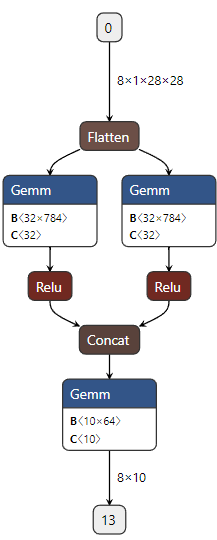

## Model = Module + methods

### training_step( )

* 내부동작의 pseudocode 
```python 
model.train() # set model.training to True 
torch.set_grad_enabled(True) # sets gradient calculation to on 
outs = []
for batch_idx, batch in enumerate(train_dataloader):
    loss = training_step(batch, batch_idx)
    outs.append(loss.detach())
    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```
* PyTorch Training Loop 
```python
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
```

**basic code**

```python
## basic code 
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.model(x) ## forward()
    loss = loss_function(y_hat, y)
    self.log('train_loss', loss)
    return loss

# call training process 
pl.trainer.fit(model, trainDataLoader, valDataLoader) 
```

### Training History logging 
>Logging from a LightningModule : 
https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html 

```python
LightningModule.log(name, value, 
    prog_bar=False, logger=True, on_step=None, on_epoch=None, reduce_fx='mean', 
    enable_graph=False, sync_dist=False, sync_dist_group=None, add_dataloader_idx=True, 
    batch_size=None, metric_attribute=None, rank_zero_only=False)
```

In [ ]:
from IPython.core.display import ProgressBar
## History logging (step level)
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.model(x)
    loss = loss_function(y_hat, y)
    self.log("loss", loss, on_step=True, on_epoch=False) 
    return loss

## History logging (epoch level)
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.model(x)
    loss = loss_function(y_hat, y)
    self.log("loss", loss, on_step=False, on_epoch=True) 
    return loss

## Display with PRogressBar 
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.model(x)
    loss = loss_function(y_hat, y)
    acc = FM.accuracy(y_hat, y)
    mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
    metrics={'loss': loss, 'acc':acc, 'mse': mse}
    self.log_dict(metrics, prog_bar=True) #on_step=True, on_epoch=False
    return loss  

In [ ]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
summary(model, input_size=(8, 1, 28, 28))  

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [8, 10]                   --
├─Model: 1-1                             [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 32]                   25,120
│    └─ReLU: 2-3                         [8, 32]                   --
│    └─Linear: 2-4                       [8, 32]                   25,120
│    └─ReLU: 2-5                         [8, 32]                   --
│    └─Linear: 2-6                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [ ]:
from pytorch_lightning.accelerators import accelerator
epochs=3
logger = pl.loggers.CSVLogger("logs", name="train_history_log")
trainer = pl.Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(model, trainDataLoader, valDataLoader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
Missing logger folder: logs/train_history_log
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 50.9 K
---------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:228: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"


In [ ]:
v_num = model.get_progress_bar_dict()['v_num']

history = pd.read_csv(f'./logs/train_history_log/version_{v_num}/metrics.csv')
history 

,loss,acc,mse,epoch,step
0,0.484522,0.879067,2.137750,0,468
1,0.229792,0.934917,1.148317,1,937
2,0.176511,0.949733,0.911300,2,1406


**self.log_dict(metrics,on_step=True, on_epoch=True)**  

|loss\_step|acc\_step|mse\_step|epoch|step|loss\_epoch|acc\_epoch|mse\_epoch|
|---|---|---|---|---|---|---|---|
|0\.8184890747070312|0\.796875|3\.8828125|0|49||||
|0\.4908294081687927|0\.8671875|3\.015625|0|99||||
|0\.4254823923110962|0\.890625|2\.3359375|0|149||||
|0\.4313923120498657|0\.859375|2\.140625|0|199||||
|0\.3025687336921692|0\.90625|1\.84375|0|249||||
|0\.2374446988105774|0\.9375|1\.2265625|0|299||||
|0\.3135235905647278|0\.9140625|1\.703125|0|349||||
|0\.1215280219912529|0\.96875|0\.7421875|0|399||||
|0\.13920900225639343|0\.9609375|0\.8125|0|449||||
||||1|468|0\.4724118113517761|0\.8768166899681091|2\.1525332927703857|
|0\.24636022746562958|0\.8984375|2\.0703125|1|499||||
|0\.2670530080795288|0\.921875|1\.75|1|549||||
|0\.21358755230903625|0\.9453125|0\.84375|1|599||||
|0\.16712963581085205|0\.953125|0\.625|1|649||||
. . . . .

**self.log_dict(metrics,on_step=False, on_epoch=True)**   

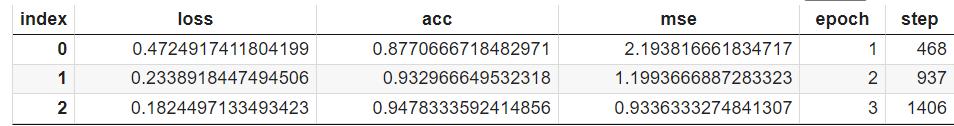

In [ ]:
history.groupby('epoch').mean().drop('step', axis=1) 

,loss,acc,mse
epoch,,,
0,0.484522,0.879067,2.137750
1,0.229792,0.934917,1.148317
2,0.176511,0.949733,0.911300


### validation_step( )

```python 
## call triaining & validation process 
trainer.fit(model, trainDataLoader, valDataLoader)
## call validation process 
trainer.validate(model, valDataLoader)
```

```python 
## basic code : step level 
def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.model(x)
    loss = F.cross_entropy(y_hat, y)
    self.log("val_loss", loss)
    return loss

## epoch level
def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.model(x)
    loss = F.cross_entropy(y_hat, y)
#    pred = ...
    return pred

def validation_epoch_end(self, validation_step_outputs):
    all_preds = torch.stack(validation_step_outputs)
#    ...

## Display with PRogressBar 
def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.model(x)
    loss = loss_function(y_hat, y)
    acc = FM.accuracy(y_hat, y)
    mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
    metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
    self.log_dict(metrics) #on_step=False, on_epoch=True
    return loss
```

In [ ]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics,prog_bar=True) #on_step=False, on_epoch=True
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [8, 10]                   --
├─Model: 1-1                             [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 32]                   25,120
│    └─ReLU: 2-3                         [8, 32]                   --
│    └─Linear: 2-4                       [8, 32]                   25,120
│    └─ReLU: 2-5                         [8, 32]                   --
│    └─Linear: 2-6                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [ ]:
epochs=3
logger = pl.loggers.CSVLogger("logs", name="val_history_log")
trainer = pl.Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(model, trainDataLoader, valDataLoader) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/val_history_log
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 50.9 K
---------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:228: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
v_num = model.get_progress_bar_dict()['v_num']
history = pd.read_csv(f'./logs/val_history_log/version_{v_num}/metrics.csv')
history  

,loss,acc,mse,epoch,step,val_loss,val_acc,val_mse
0,0.798518,0.843750,2.906250,0,49,NaN,NaN,NaN
1,0.437703,0.882812,2.007812,0,99,NaN,NaN,NaN
2,0.407454,0.875000,2.320312,0,149,NaN,NaN,NaN
3,0.290018,0.914062,1.007812,0,199,NaN,NaN,NaN
4,0.246821,0.937500,1.484375,0,249,NaN,NaN,NaN
5,0.235401,0.906250,1.281250,0,299,NaN,NaN,NaN
6,0.212183,0.937500,1.609375,0,349,NaN,NaN,NaN
7,0.336716,0.914062,1.804688,0,399,NaN,NaN,NaN
8,0.309757,0.882812,1.757812,0,449,NaN,NaN,NaN
9,NaN,NaN,NaN,0,468,0.261410,0.9234,1.3406


In [ ]:
trainer.validate(model,valDataLoader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.95169997215271
        val_loss            0.16202324628829956
         val_mse            0.8499000072479248
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_acc': 0.95169997215271,
  'val_loss': 0.16202324628829956,
  'val_mse': 0.8499000072479248}]

In [ ]:
history.groupby('epoch').last().drop('step', axis=1)

,loss,acc,mse,val_loss,val_acc,val_mse
epoch,,,,,,
0,0.309757,0.882812,1.757812,0.261410,0.9234,1.3406
1,0.202463,0.953125,0.960938,0.196659,0.9433,1.0261
2,0.238449,0.929688,2.078125,0.162023,0.9517,0.8499


### test_step( )

In [ ]:
def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = loss_function(y_hat, y)
    acc = FM.accuracy(y_hat, y)
    metrics={'test_loss': loss, 'test_acc':acc}
    self.log_dict(metrics) #on_step=False, on_epoch=True

In [ ]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        metrics={'test_loss': loss, 'test_acc':acc}
        self.log_dict(metrics)  
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
summary(model, input_size=(8, 1, 28, 28))

epochs=3
trainer = pl.Trainer(max_epochs=epochs, accelerator='auto')
trainer.fit(model, trainDataLoader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 50.9 K
---------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:228: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:228: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"


In [ ]:
trainer.validate(model, valDataLoader)
trainer.test(model, valDataLoader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9496999979019165
        val_loss            0.16707918047904968
         val_mse            0.9205999970436096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9496999979019165
        test_loss           0.16707918047904968
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9496999979019165, 'test_loss': 0.16707918047904968}]

### predict_step( )

**forward( )를 overide하여 학습된 모델을 실행하는 별도의 process를 생성 가능** 

In [ ]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def predict_step(self, x, batch_idx):
        y_pred = self(x) 
        y_pb = nn.Softmax(y_pred)
        return y_pb

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
summary(model, input_size=(8, 1, 28, 28))

epochs=3
trainer = pl.Trainer(max_epochs=epochs, accelerator='auto')
trainer.fit(model, trainDataLoader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 50.9 K
---------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/progress/base.py:228: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  f"The progress bar already tracks a metric with the name(s) '{', '.join(duplicates)}' and"


In [ ]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))
y_predict = model(batch[0])       # model <- image only 
p(y_predict,'\n')                 # (128,10) 

Shape:torch.Size([128, 10])
Type: <class 'torch.Tensor'>
Values: tensor([[ -2.1668,  -7.7950,   0.1752,  ...,   9.4182,  -2.7660,  -0.0729],
        [  0.6736,  -1.4034,   8.6410,  ..., -12.2791,  -1.3000, -11.0657],
        [ -4.5876,   5.0435,  -0.4238,  ...,  -0.8427,  -1.1379,  -3.0398],
        ...,
        [ -8.1212,  -3.3665,  -1.1043,  ...,  -2.6093,  -1.5335,   2.3996],
        [  3.8079,  -4.2771,   0.3259,  ...,  -1.2976,  -3.6735,   0.6141],
        [ -4.5428,  -3.3744,  -4.1905,  ...,  -7.6738,  -0.1922,  -2.6186]],
       grad_fn=<AddmmBackward0>)



In [ ]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))
# forward()실행
y_predict = model(batch[0])       # model <- image only 
p(y_predict[0],'\n')              # 첫image에 대한 출력(logit) 
# predict_step()실행
y_predict = trainer.predict(model,batch[0]) # model <- image only 
p(y_predict[0],'\n')              #  첫image에 대한 출력(prob.)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([ -2.1668,  -7.7950,   0.1752,   2.6023,  -7.3329,  -0.8161, -12.8258,
          9.4182,  -2.7660,  -0.0729], grad_fn=<SelectBackward0>)



Predicting: 469it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Type: <class 'torch.nn.modules.activation.Softmax'>
Values: Softmax(
  dim=tensor([[ -2.1668,  -7.7950,   0.1752,   2.6023,  -7.3329,  -0.8161, -12.8258,
             9.4182,  -2.7660,  -0.0729]], device='cuda:0')
)



In [ ]:
class LitMCdropoutModel(pl.LightningModule):
    def __init__(self, model, mc_iteration):
        super().__init__()
        self.model = model
        self.dropout = nn.Dropout()
        self.mc_iteration = mc_iteration

    def predict_step(self, batch, batch_idx):
        # enable Monte Carlo Dropout
        self.dropout.train() ## train flag
        # take average of `self.mc_iteration` iterations # torch.unsqueeze(0):(new_axis,...) 
        pred = torch.vstack([self.dropout(self.model(x)).unsqueeze(0) for _ in range(self.mc_iteration)]).mean(dim=0)
        return pred

## Inference / Prediction

In [ ]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))
## Sets the module in evaluation mode.(Dropout,BN,..)
model.eval() 
y_predict = model(batch[0])       # model <- image only 
p(y_predict,'\n')                 # (128,10) 
p(y_predict[0,:],'\n')            # (10,) 
p(y_predict[0,:].detach(),'\n')   # (10,) w/o grad_fn
p(np.argmax(y_predict[0,:].detach()).numpy(),'np') # index      
p(np.argmax(y_predict[0,:].detach()),'tensor') # index tensor     
p(np.argmax(y_predict[0,:])) ## Error: Can't call numpy() on Tensor that requires grad.

Shape:torch.Size([128, 10])
Type: <class 'torch.Tensor'>
Values: tensor([[ -2.1668,  -7.7950,   0.1752,  ...,   9.4182,  -2.7660,  -0.0729],
        [  0.6736,  -1.4034,   8.6410,  ..., -12.2791,  -1.3000, -11.0657],
        [ -4.5876,   5.0435,  -0.4238,  ...,  -0.8427,  -1.1379,  -3.0398],
        ...,
        [ -8.1212,  -3.3665,  -1.1043,  ...,  -2.6093,  -1.5335,   2.3996],
        [  3.8079,  -4.2771,   0.3259,  ...,  -1.2976,  -3.6735,   0.6141],
        [ -4.5428,  -3.3744,  -4.1905,  ...,  -7.6738,  -0.1922,  -2.6186]],
       grad_fn=<AddmmBackward0>)

Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([ -2.1668,  -7.7950,   0.1752,   2.6023,  -7.3329,  -0.8161, -12.8258,
          9.4182,  -2.7660,  -0.0729], grad_fn=<SliceBackward0>)

Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([ -2.1668,  -7.7950,   0.1752,   2.6023,  -7.3329,  -0.8161, -12.8258,
          9.4182,  -2.7660,  -0.0729])

<<np>>:
Shape:()
Type: <class 'numpy.ndarray'>
Va

RuntimeError: ignored

In [ ]:
batch = next(iter(valDataLoader)) # ((128,1,28,28),(128,10))
## Sets the module in evaluation mode.(Dropout,BN,..)
model.eval() 

## disabled gradient calculation.(reduce memory)
with torch.no_grad(): ## w/o grad_fn object 
    y_predict = model(batch[0])       # model <- image only 
p(y_predict,'\n')                 # (128,10) 
p(y_predict[0,:],'\n')            # (10,) 
p(y_predict[0,:].detach(),'\n')   # (10,) w/o grad_fn
p(np.argmax(y_predict[0,:].detach()).numpy(),'np') # index      
p(np.argmax(y_predict[0,:].detach()),'tensor') # index tensor     
p(np.argmax(y_predict[0,:])) # index tensor     

Shape:torch.Size([128, 10])
Type: <class 'torch.Tensor'>
Values: tensor([[ -2.1668,  -7.7950,   0.1752,  ...,   9.4182,  -2.7660,  -0.0729],
        [  0.6736,  -1.4034,   8.6410,  ..., -12.2791,  -1.3000, -11.0657],
        [ -4.5876,   5.0435,  -0.4238,  ...,  -0.8427,  -1.1379,  -3.0398],
        ...,
        [ -8.1212,  -3.3665,  -1.1043,  ...,  -2.6093,  -1.5335,   2.3996],
        [  3.8079,  -4.2771,   0.3259,  ...,  -1.2976,  -3.6735,   0.6141],
        [ -4.5428,  -3.3744,  -4.1905,  ...,  -7.6738,  -0.1922,  -2.6186]])

Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([ -2.1668,  -7.7950,   0.1752,   2.6023,  -7.3329,  -0.8161, -12.8258,
          9.4182,  -2.7660,  -0.0729])

Shape:torch.Size([10])
Type: <class 'torch.Tensor'>
Values: tensor([ -2.1668,  -7.7950,   0.1752,   2.6023,  -7.3329,  -0.8161, -12.8258,
          9.4182,  -2.7660,  -0.0729])

<<np>>:
Shape:()
Type: <class 'numpy.ndarray'>
Values: 7
<<tensor>>:
Shape:torch.Size([])
Type: <class 'torc

In [ ]:
p(np.argmax(model(batch[0]).detach(),axis=1).numpy(),'\n') 
p(batch[1])

Shape:(128,)
Type: <class 'numpy.ndarray'>
Values: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 4 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 4 9 0 5]

<<>>:
Shape:torch.Size([128])
Type: <class 'torch.Tensor'>
Values: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])


**rank, shape, axis**

In [ ]:
## rank, shape, axis 
d = np.zeros((2,3,4))
print(d.ndim)  
p(d)
# #of_rank = 3
# shape=(2,3,4), 
# axis:(0,1,2) or (0,1,-1) 
#     (z, y, x)

3
<<>>:
Shape:(2, 3, 4)
Type: <class 'numpy.ndarray'>
Values: [[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


# 좀더 깊숙한 모델 다루기 

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten =  nn.Flatten()
        self.linear1 = nn.Linear(28*28, 32)
        self.linear2 = nn.Linear(28*28, 32)
        self.linear3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.flatten(x)
        x1 = self.linear1(x)
        x1 = self.relu(x1)
        x2 = self.linear2(x)
        x2 = self.relu(x2)
        x = torch.cat([x1, x2], dim=1)
        x = self.linear3(x)
        return x

# model = Model()
# summary(model, input_size=(8, 1, 28, 28))

In [ ]:
loss_function = nn.CrossEntropyLoss()
class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def predict_step(self, x, batch_idx):
        y_pred = self(x) 
        y_pb = nn.Softmax(y_pred)
        return y_pb

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True
        return 

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = loss_function(y_hat, y)
        acc = FM.accuracy(y_hat, y)
        mse = FM.mean_squared_error(torch.argmax(y_hat, dim=1), y)
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True
        return 

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
#summary(model, input_size=(8, 1, 28, 28))

### DataModule 만들기 

https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09 

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import DataLoader
class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, data_dir: str = '', batch_size: int = 32):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
  def setup(self, stage):
    # transforms for images 
    transform=transforms.Compose([transforms.ToTensor(), # 1/255,tensor로 변환
                                  transforms.Normalize((0.1307,), (0.3081,))])
    self.mnist_test = MNIST(self.data_dir, train=False, transform=transform)
    mnist_full = MNIST(self.data_dir, train=True, transform=transform)
    self.mnist_train, self.mnist_val = data.random_split(mnist_full, [55000, 5000])
  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=self.batch_size)
  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=self.batch_size)
  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [ ]:
data_module = MNISTDataModule(batch_size=1024)
model = MyModel()
trainer = pl.Trainer(max_epochs=3, accelerator='auto')
trainer.fit(model, data_module) 

NameError: ignored

In [ ]:
trainer.validate(model, data_module) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9377999901771545
        val_loss            0.22476987540721893
         val_mse            1.0288000106811523
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_acc': 0.9377999901771545,
  'val_loss': 0.22476987540721893,
  'val_mse': 1.0288000106811523}]

In [ ]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9343000054359436
        val_loss            0.23118965327739716
         val_mse            1.1490000486373901
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_acc': 0.9343000054359436,
  'val_loss': 0.23118965327739716,
  'val_mse': 1.1490000486373901}]

## Loss / Metric 함수

**내장 Loss Func.** 
> torch.nn.functional  
* mse_loss      : element-wise mean squared error.  
* cross_entropy : cross entropy loss between input(logit) and target(prob.).  
* binary_cross_entropy : Binary Cross Entropy between the target and input probabilities.  
* binary_cross_entropy_with_logits :  Binary Cross Entropy between target and input logits.  
* kl_div : Kullback-Leibler divergence Loss  
* l1_loss : mean element-wise absolute value difference.  
* smooth_l1_loss : uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise.   
* nll_loss : negative log likelihood loss.  
* poisson_nll_loss : Poisson negative log likelihood loss.  
* gaussian_nll_loss : Gaussian negative log likelihood loss.  
...

**Matric Func.** 
> torchmetrics : https://torchmetrics.readthedocs.io/en/stable/regression/mean_absolute_error.html   
 

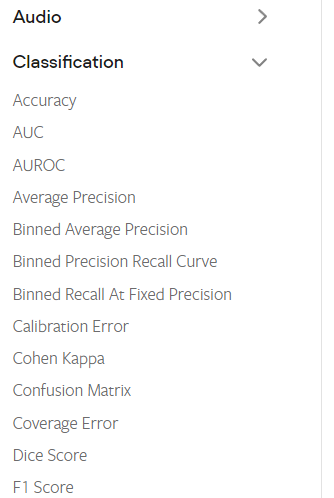 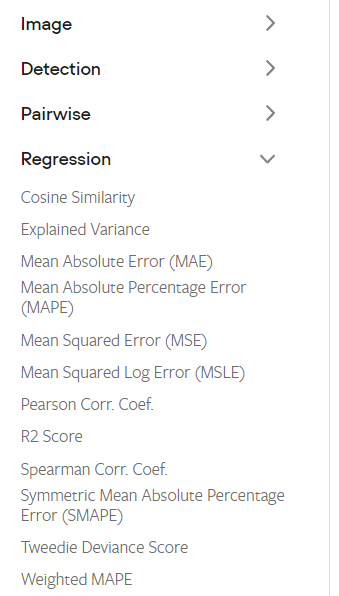

###  사용자 loss, metric함수 만들기

In [ ]:
class Onehot(object):        
    def __call__(self, sample):
        sample = sample
        target = np.eye(10)[sample]
        return torch.FloatTensor(target)
        
# MSE 계산을 위해 target을 one-hot encoding 
target_transform = transforms.Compose([Onehot()])
mnist_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST('', transform=mnist_transform, target_transform=target_transform, train=True)
test_dataset = MNIST('', transform=mnist_transform, target_transform=target_transform, train=False)

batch_size=128
trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten =  nn.Flatten()
        self.linear1 = nn.Linear(28*28, 32)
        self.linear2 = nn.Linear(28*28, 32)
        self.linear3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.flatten(x)
        x1 = self.linear1(x)
        x1 = self.relu(x1)
        x2 = self.linear2(x)
        x2 = self.relu(x2)
        x = torch.cat([x1, x2], dim=1)
        x = self.linear3(x)
        return x

In [ ]:
# loss 함수 만들기
def custom_mean_squared_error(pred, target):
    error = torch.mean(torch.square(pred - target))
    return error

# metric 함수 만들기
def custom_mean_error(y_pred, y_true):
    error = torch.mean(y_true - y_pred)
    return error

class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  Model()

    def forward(self, x):
        out = self.layers(x)
        out = torch.softmax(out, dim=-1) ##
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = custom_mean_squared_error(y_pred, y)
        error = custom_mean_error(y_pred, y)
        metrics={'loss':loss, 'error':error}
        self.log_dict(metrics)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = custom_mean_squared_error(y_pred, y)
        error = custom_mean_error(y_pred, y)
        metrics = {'val_loss':loss, 'val_error':error}
        self.log_dict(metrics)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = MyModel()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [8, 10]                   --
├─Model: 1-1                             [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 32]                   25,120
│    └─ReLU: 2-3                         [8, 32]                   --
│    └─Linear: 2-4                       [8, 32]                   25,120
│    └─ReLU: 2-5                         [8, 32]                   --
│    └─Linear: 2-6                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [ ]:
epochs=3
name="custom_losses"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(model, trainDataLoader, valDataLoader) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/custom_losses
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type  | Params
---------------------------------
0 | layers | Model | 50.9 K
---------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
v_num = model.get_progress_bar_dict()['v_num']
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
history

,loss,error,epoch,step,val_loss,val_error
0,0.028600,-3.725290e-10,0,49,NaN,NaN
1,0.017853,-4.656613e-11,0,99,NaN,NaN
2,0.014835,3.725290e-10,0,149,NaN,NaN
3,0.012156,3.026799e-10,0,199,NaN,NaN
4,0.014549,1.396984e-10,0,249,NaN,NaN
5,0.017729,8.847564e-10,0,299,NaN,NaN
6,0.010426,1.303852e-09,0,349,NaN,NaN
7,0.012862,1.862645e-10,0,399,NaN,NaN
8,0.013508,-4.656613e-11,0,449,NaN,NaN
9,NaN,NaN,0,468,0.011601,-1.404341e-10


In [ ]:
#history.groupby('epoch').mean().drop('step', axis=1)
history.groupby('epoch').last().drop('step', axis=1)

,loss,error,val_loss,val_error
epoch,,,,
0,0.013508,-4.656613e-11,0.011601,-1.404341e-10
1,0.011618,1.629814e-10,0.009649,-5.592593e-11
2,0.009358,2.793968e-10,0.007844,3.848694e-12


## configure_optimizers( )  
**Optimization Algorithms + Learning rate schedueling**



### Optimizer 
https://pytorch.org/docs/stable/optim.html#module-torch.optim    

Adadelta : Implements Adadelta algorithm.

Adagrad  : Implements Adagrad algorithm.

Adam : Implements Adam algorithm.

NAdam : Implements NAdam algorithm.

RMSprop : Implements RMSprop algorithm.

SGD : Implements stochastic gradient descent (optionally with momentum).  
....
```python
torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, *, maximize=False)
torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False, *, maximize=False)
```

**기본 구조** 

In [ ]:
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler 

# no learning rate scheduler
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-3)

# multiple optimizer case (e.g.: GAN)
def configure_optimizers(self):
    gen_opt = Adam(self.model_gen.parameters(), lr=0.01)
    dis_opt = Adam(self.model_dis.parameters(), lr=0.02)
    return gen_opt, dis_opt

# multi-optimizer has its own scheduler(step decay)
def configure_optimizers(self):
    gen_opt = Adam(self.model_gen.parameters(), lr=0.01)
    dis_opt = Adam(self.model_dis.parameters(), lr=0.02)
    gen_sch = {
        'scheduler': lr_scheduler.ExponentialLR(gen_opt, 0.99),
        'interval': 'step'  # called after each training step
    }
    dis_sch = lr_scheduler.ExponentialLR(dis_opt, 0.99) # called every epoch
    return [gen_opt, dis_opt], [gen_sch, dis_sch]

### Learning rate scheduling 

In [ ]:
def configure_optimizers(self):
    optimizer = Adam(self.model_gen.parameters(), lr=0.01)
    
## StepLR 
    lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    # Assuming optimizer uses lr = 0.05 for all groups
    # lr = 0.05     if epoch < 30
    # lr = 0.005    if 30 <= epoch < 60
    # lr = 0.0005   if 60 <= epoch < 90
    # ...

## MultiStepLR
    lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    # Assuming optimizer uses lr = 0.05 for all groups
    # lr = 0.05     if epoch < 30
    # lr = 0.005    if 30 <= epoch < 80
    # lr = 0.0005   if epoch >= 80

## LambdaLR
    # Assuming optimizer has two groups.
    lambda1 = lambda epoch: epoch // 30
    lambda2 = lambda epoch: 0.95 ** epoch
    lr_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])

## ExponentialLR
    gamma=0.98
    lr_scheduler=lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=- 1, verbose=False)

    return [optimizer], [lr_scheduler]

```python
def configure_optimizers(self):
    optimizer = Adam(self.model.parameters(), lr=0.01)
    # Assuming optimizer has two groups.
    lambda1 = lambda epoch: epoch // 30
    lambda2 = lambda epoch: 0.95 ** epoch
    lr_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
    return [optimizer], [lr_scheduler]
```    

### Coustom Learning rate scheduling 

In [ ]:
def lr_polt(lr_s,epochs=100,lr_start=0.01):
  lr=[]
  for step in range(epochs):
      lr.append(lr_s(step)*lr_start)
  plt.plot(lr, linestyle='--', label="delayed_Exp_decay")
  plt.legend()
  plt.grid()
  plt.show()

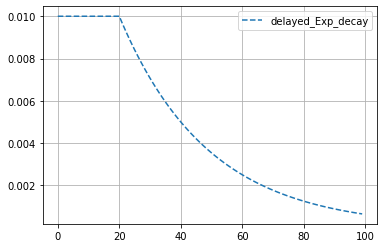

In [ ]:
lr_start = 0.01
decay_steps = 20
gamma = 0.5
delay = 20

d_scheduler = lambda epoch: gamma**(
                max(0,epoch-delay) / decay_steps) 

lr_polt(d_scheduler,epochs=100) 

ExponentialDecay

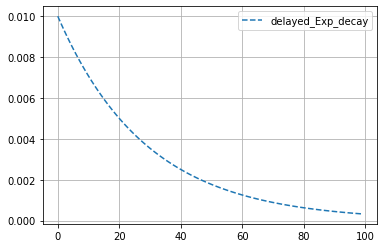

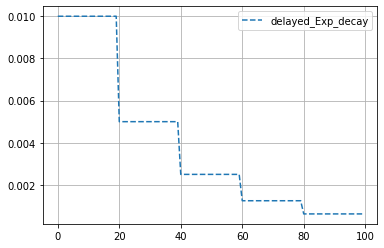

In [ ]:
decay_steps = 20  
gamma=0.5

exponential_decay = lambda epoch: gamma**(epoch / decay_steps) 
exponential_decay_step = lambda epoch: gamma**(epoch // decay_steps) 

lr_start = 0.01
lr_polt(exponential_decay,epochs=100)
lr_polt(exponential_decay_step,epochs=100)

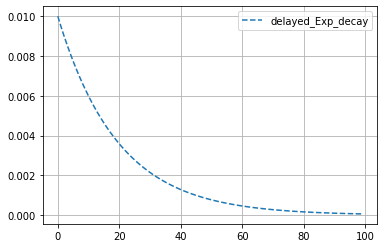

In [ ]:
## lr_scheduler.ExponentialLR() : decay_steps = 1
decay_steps = 1  
gamma=0.95

exponential_decay = lambda epoch: gamma**(epoch / decay_steps) 

lr_polt(exponential_decay,epochs=100)

PolynomialDecay

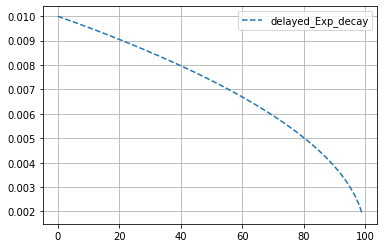

In [ ]:
lr_start = 0.01
end_lrate = 0.001
decay_steps = epochs = 100
power=0.5

PolynomialDecay = lambda epoch: (((lr_start - end_lrate) 
              * ((1 - epoch / decay_steps) ** (power)) )
            + end_lrate)/lr_start 

lr_polt(PolynomialDecay,epochs=epochs,lr_start=lr_start)

InverseTimeDecay

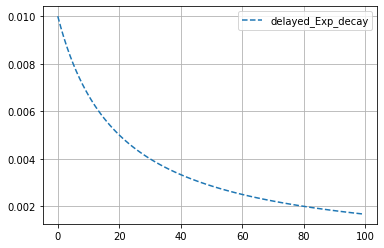

In [ ]:
decay_steps = 10
decay_rate = 0.5

InverseTimeDecay = lambda epoch: 1 / (1 + 
              decay_rate * epoch / decay_steps) 

lr_polt(InverseTimeDecay,epochs=100)

### LR scheduling 적용

In [ ]:
lr = 0.005
loss_function = nn.CrossEntropyLoss()

class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.Linear(64,10) 
            )  
    def forward(self, x):
        out = self.layers(x)
        return out
 
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        metrics = {'loss':loss, 'acc':acc}
#        self.log_dict(metrics)        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        metrics = {'val_loss':loss, 'val_acc':acc}
#        self.log_dict(metrics,prog_bar=True,on_step=True,on_epoch=False)        
        self.log_dict(metrics,prog_bar=True,on_step=False,on_epoch=True)        
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        return optimizer

model = MyModel()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  --                        --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 64]                   50,240
│    └─Linear: 2-3                       [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [ ]:
mnist_transform = transforms.Compose([transforms.ToTensor()])
#train_dataset = MNIST('', transform=mnist_transform, train=True, download=True)
test_dataset = MNIST('', transform=mnist_transform, train=False, download=True)
mnist_train, mnist_val = data.random_split(test_dataset, [6000, 4000])

batch_size=200
trainDataLoader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
valDataLoader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

In [ ]:
%%time
model = MyModel()
epoch=30
name="model_defaults"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=epoch, logger=logger, accelerator='auto')
trainer.fit(model, trainDataLoader, val_dataloaders=valDataLoader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.9 K
--------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

CPU times: user 29.6 s, sys: 483 ms, total: 30.1 s
Wall time: 30.5 s


CPU times: user 27.9 s, sys: 432 ms, total: 28.3 s  
Wall time: 28.7 s

In [ ]:
v_num = model.get_progress_bar_dict()['v_num']
meric_file = f'./logs/{name}/version_{v_num}/metrics.csv'
history1 = pd.read_csv(meric_file)
print(meric_file)
history1

In [ ]:
max = history1['val_acc'].max()
print(f'Max Acc:{max}')
history1_plot = history1.drop('step', axis=1)#.groupby('epoch').mean()
plt.plot(history1_plot['val_acc'], linestyle='--', label="val_acc")
plt.plot(history1_plot['val_loss'], linestyle='--', label="val_loss")
plt.title("No Schedule")
# plt.ylim(0.1, 1)
plt.legend()
plt.grid()

Max Acc:0.912750005722046  
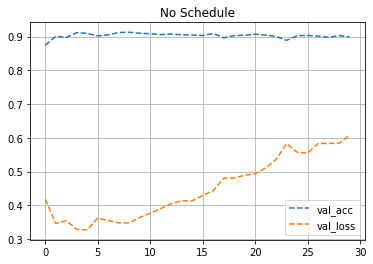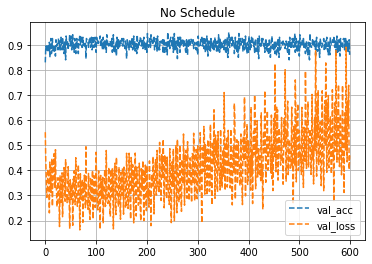 


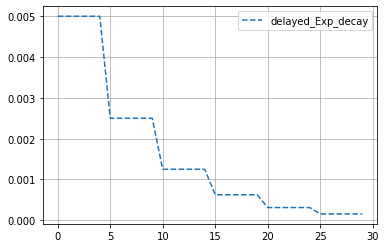

In [ ]:
decay_steps = 5
gamma=0.5
exponential_decay_step = lambda epoch: gamma**(epoch // decay_steps) 

lr_polt(exponential_decay_step,epochs=epoch,lr_start=lr)

**Custom lr-scheduler 적용**

In [ ]:
decay_steps = 5
gamma=0.5
exponential_decay_step = lambda epoch: gamma**(epoch // decay_steps) 

class Model_expDeacy(MyModel):
    def __init__(self):
        super(Model_expDeacy, self).__init__()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        lr_s = lr_scheduler.LambdaLR(optimizer, 
                                     lr_lambda = exponential_decay_step, verbose=True)
        return [optimizer], [lr_s]   

In [ ]:
model_exp = Model_expDeacy()
name2="model_exp_decay"
logger = pl.loggers.CSVLogger("logs", name=name2)
trainer = pl.Trainer(max_epochs=epoch, logger=logger, accelerator='auto')
trainer.fit(model_exp, trainDataLoader, valDataLoader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.9 K
--------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 5.0000e-03.


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Validation: 0it [00:00, ?it/s]

In [ ]:
v_num2 = model_exp.get_progress_bar_dict()['v_num']
meric_file = f'./logs/{name2}/version_{v_num2}/metrics.csv'
print(meric_file)

history2 = pd.read_csv(meric_file)
history2

In [ ]:
max2 = history2['val_acc'].max()
print(f'Max Acc:{max2}')
history2 = pd.read_csv(meric_file)
history2_plot = history2.drop('step', axis=1)#.groupby('epoch').mean()
plt.plot(history2_plot['val_acc'], linestyle='--', label="val_acc")
plt.plot(history2_plot['val_loss'], linestyle='--', label="val_loss")
plt.title("Exp_decay Schedule")
# plt.ylim(0.1, 1)
plt.legend()
plt.grid()

Max Acc:0.9162499904632568  
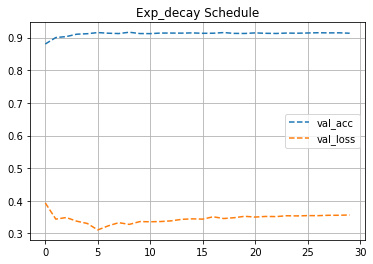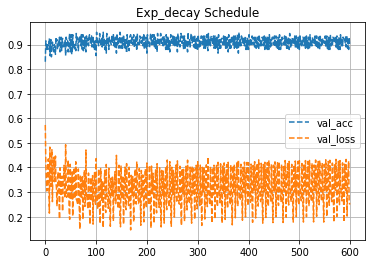

In [ ]:
print(f'Normal Model Max Acc:{max}\nlr_scheduling Model Max Acc:{max2}')
plt.plot(history1_plot['val_acc'], linestyle='--', label="normal_val_acc")
plt.plot(history2_plot['val_acc'], linestyle='-', label="lr_schedule_val_acc")
plt.plot(history1_plot['val_loss'], linestyle='--', label="normal_val_loss")
plt.plot(history2_plot['val_loss'], linestyle='-', label="lr_schedule_val_loss")
plt.title("Exp_decay Schedule")
# plt.ylim(0.1, 1)
plt.legend()
plt.grid()
plt.show() 

Normal Model Max Acc:0.912750005722046  
lr_scheduling Model Max Acc:0.9162499904632568  
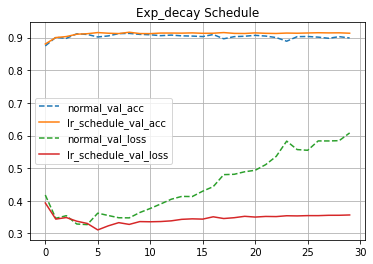  
Normal Model Max Acc:0.949999988079071  
lr_scheduling Model Max Acc:0.949999988079071  
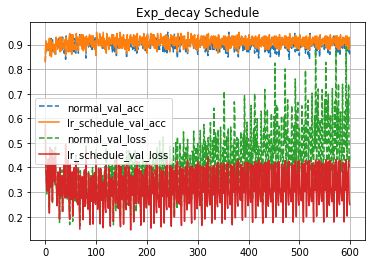


In [ ]:
!rm -rf ./logs 

## pl.Trainer( )  

**Reproducibility**

In [ ]:
pl.seed_everything(42, workers=True)
trainer = pl.Trainer(deterministic=True) 

Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1815: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,


### TensorBoard 연동

>!rm -rf ./logs/    #colab(linux)    
>#*jupyter notebook 내에서 보기위해*   
>%load_ext tensorboard  
>#*로그 패스와 함께 텐서보드 실행*  
>%tensorboard --logdir ./logs  

In [ ]:
%load_ext tensorboard  
%tensorboard --logdir ./tb_logs  

#### Model 실행

In [ ]:
loss_function = nn.CrossEntropyLoss()
class Model(pl.LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten =  nn.Flatten()
        self.linear1 = nn.Linear(28*28, 32)
        self.linear2 = nn.Linear(28*28, 32)
        self.linear3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x0 = self.flatten(x)
        x1 = self.linear1(x0)
        x1 = self.relu(x1)
        x2 = self.linear2(x0)
        x2 = self.relu(x2)
        x3 = torch.cat([x1, x2], dim=1)
        x4 = self.linear3(x3)
        return x4
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = Model()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Flatten: 1-1                           [8, 784]                  --
├─Linear: 1-2                            [8, 32]                   25,120
├─ReLU: 1-3                              [8, 32]                   --
├─Linear: 1-4                            [8, 32]                   25,120
├─ReLU: 1-5                              [8, 32]                   --
├─Linear: 1-6                            [8, 10]                   650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.23

In [ ]:
model = Model()

logger = pl.loggers.TensorBoardLogger("tb_logs", name="my_model")
trainer = pl.Trainer(max_epochs=20, logger=logger, accelerator='auto')
trainer.fit(model, trainDataLoader, valDataLoader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/my_model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | linear1 | Linear  | 25.1 K
2 | linear2 | Linear  | 25.1 K
3 | linear3 | Linear  | 650   
4 | relu    | ReLU    | 0     
------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Call Back 

**Callbacks API(Built-in Callbacks)**

* EarlyStopping : Monitor a metric and stop training when it stops improving.
* ModelCheckpoint : Save the model periodically by monitoring a quantity.
---  
* LambdaCallback : Create a simple callback on the fly using lambda functions.
* Callback : Abstract base class used to build new callbacks.
---
* ModelSummary : Generates a summary of all layers in a LightningModule.
* RichModelSummary : Generates a summary of all layers in a LightningModule with rich text formatting.
---
* LearningRateMonitor : Automatically monitor and logs learning rate for learning rate schedulers during training.
* TQDMProgressBar : This is the default progress bar used by Lightning.
* ProgressBarBase : The base class for progress bars in Lightning.
* RichProgressBar : Create a progress bar with rich text formatting.
* DeviceStatsMonitor : Automatically monitors and logs device stats during training stage.
* Timer : The Timer callback tracks the time spent in the training, validation, and test loops and interrupts the Trainer if the given time limit for the training loop is reached.
---
* ModelPruning : Model pruning Callback, using PyTorch's prune utilities.
* QuantizationAwareTraining : Quantization allows speeding up inference and decreasing memory requirements by performing computations and storing tensors at lower bitwidths (such as INT8 or FLOAT16) than floating point precision.
* GradientAccumulationScheduler : Change gradient accumulation factor according to scheduling.
* StochasticWeightAveraging : Implements the Stochastic Weight Averaging (SWA) Callback to average a model.



#### EarlyStopping 

```python
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
EarlyStopping(monitor, min_delta=0.0, patience=3, verbose=False, mode='min',   
              strict=True, check_finite=True, stopping_threshold=None,
              divergence_threshold=None, check_on_train_epoch_end=None)
```

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
    
trainer = pl.Trainer(callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1815: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,


In [ ]:
logger = pl.loggers.CSVLogger("logs", name="model_custom_losses")
trainer = pl.Trainer(max_epochs=100, logger=logger, 
                     callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
trainer.fit(model, trainDataLoader, val_dataloaders=valDataLoader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1815: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
Missing logger folder: logs/model_custom_losses

  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | linear1 | Linear  | 25.1 K
2 | linear2 | Linear  | 25.1 K
3 | linear3 | Linear  | 650   
4 | relu    | ReLU    | 0     
------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

#### ModelCheckPoint 저장하기

 Parameters & default values


---
```python
pl.callbacks.ModelCheckpoint(
  dirpath='./projecA', 
  filename='{epoch}-{val_loss:.2f}-{val_acc:.2f}', 
  monitor=None,                # 기준 metric 
  verbose=False,               
  save_last=None,              
  save_top_k=1,                # -1:all model save
  save_weights_only=False,     #default: model save 
  mode='min',                  #'max'@accuracy 
  auto_insert_metric_name=True,#file name에 추가 
  every_n_train_steps=None,    #
  train_time_interval=None,    
  every_n_epochs=None,         # 
  save_on_train_epoch_end=None)#False:save@end_validation 
```
---

In [ ]:
# colab(linux)
!rm -rf ./logs/*
!rm -rf ./aicamp/*
# windows
# code/logs code/aicamp 폴더 삭제해 주세요

***code/aicamp 폴더 삭제해 주세요***

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath='./aicamp/',
    filename='{epoch:02d}-{val_acc:.4f}',
    save_top_k=2)
logger = pl.loggers.TensorBoardLogger("tb_logs", name="sample-mnist")
trainer = pl.Trainer(max_epochs=3, logger=logger, 
                     callbacks=[checkpoint_callback],accelerator='auto')
trainer.fit(model, trainDataLoader, val_dataloaders=valDataLoader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /content/aicamp exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | linear1 | Linear  | 25.1 K
2 | linear2 | Linear  | 25.1 K
3 | linear3 | Linear  | 650   
4 | relu    | ReLU    | 0     
------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%ls 'aicamp' 

'epoch=01-val_acc=0.9761.ckpt'  'epoch=02-val_acc=0.9729.ckpt'


In [ ]:
# file name 수정!! 
checkpoint_path = "aicamp/epoch=01-val_acc=0.8855.ckpt"
# 모델 읽어오기
new_model = model.load_from_checkpoint(checkpoint_path)
trainer.validate(new_model, valDataLoader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8855000138282776
        val_loss            0.43907469511032104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_acc': 0.8855000138282776, 'val_loss': 0.43907469511032104}]

#### Custom Callback 만들기

**Callback Hooks**
```python
setup   : fit, validate, test, predict, or tune begins.  
teardown: fit, validate, test, predict, or tune ends.

on_fit_start: fit begins.
on_fit_end  :  

on_train_batch_start: train batch begins.
on_train_batch_end
on_train_epoch_start: train epoch begins. 
on_train_epoch_end

on_validation_batch_start 
on_validation_batch_end
on_validation_epoch_start
on_validation_epoch_end

on_test_batch_start
on_test_batch_end
on_test_epoch_start
on_test_epoch_end

on_predict_batch_start
on_predict_batch_end
on_predict_epoch_start
on_predict_epoch_end

on_train_start
on_train_end
on_validation_start
on_validation_end
on_test_start
on_test_end
on_predict_start
on_predict_end

on_sanity_check_start: validation sanity check starts. 
on_sanity_check_end

on_exception
state_dict
load_state_dict
on_save_checkpoint
on_load_checkpoint
on_before_backward
on_after_backward
on_before_optimizer_step
on_before_zero_grad
```

In [ ]:
class MyPrintingCallback(pl.Callback):
    def on_train_start(self, trainer, pl_module):
        self.losses = []

    def on_train_epoch_start(self, trainer, pl_module):
        print(f'Epoch : {trainer.current_epoch}')

    def on_train_batch_end(self, *args, **kwargs):
        loss = trainer.callback_metrics['loss']
        self.losses.append(loss)
        print(f'Batch:{trainer.global_step}, loss:{loss}')

model = Model()

logger = pl.loggers.TensorBoardLogger("tb_logs", name="sample-mnist")
trainer = pl.Trainer(max_epochs=3, logger=logger, accelerator='auto',
                     callbacks=[MyPrintingCallback()])
trainer.fit(model, trainDataLoader, val_dataloaders=valDataLoader) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/sample-mnist
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | linear1 | Linear  | 25.1 K
2 | linear2 | Linear  | 25.1 K
3 | linear3 | Linear  | 650   
4 | relu    | ReLU    | 0     
------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Epoch : 0
Batch:1, loss:2.2931299209594727
Batch:2, loss:2.2680459022521973
Batch:3, loss:2.2500741481781006
Batch:4, loss:2.2084028720855713
Batch:5, loss:2.1663873195648193
Batch:6, loss:2.1067397594451904
Batch:7, loss:2.1045608520507812
Batch:8, loss:2.063791036605835
Batch:9, loss:2.0312020778656006
Batch:10, loss:1.9657402038574219
Batch:11, loss:1.8975762128829956
Batch:12, loss:1.8759437799453735
Batch:13, loss:1.8480721712112427
Batch:14, loss:1.7900450229644775
Batch:15, loss:1.7837523221969604
Batch:16, loss:1.7230521440505981
Batch:17, loss:1.645426630973816
Batch:18, loss:1.6824300289154053
Batch:19, loss:1.6547331809997559
Batch:20, loss:1.537111759185791
Batch:21, loss:1.6309067010879517
Batch:22, loss:1.4398117065429688
Batch:23, loss:1.4487252235412598
Batch:24, loss:1.3983198404312134
Batch:25, loss:1.352638840675354
Batch:26, loss:1.2864065170288086
Batch:27, loss:1.3458888530731201
Batch:28, loss:1.3426775932312012
Batch:29, loss:1.2096962928771973
Batch:30, loss:1.

Validation: 0it [00:00, ?it/s]

Epoch : 1
Batch:470, loss:0.21149411797523499
Batch:471, loss:0.19738872349262238
Batch:472, loss:0.319549024105072
Batch:473, loss:0.319428414106369
Batch:474, loss:0.27338358759880066
Batch:475, loss:0.17221184074878693
Batch:476, loss:0.5367507338523865
Batch:477, loss:0.21441473066806793
Batch:478, loss:0.14057888090610504
Batch:479, loss:0.2978573143482208
Batch:480, loss:0.18284684419631958
Batch:481, loss:0.21984253823757172
Batch:482, loss:0.24829624593257904
Batch:483, loss:0.2059788703918457
Batch:484, loss:0.34841910004615784
Batch:485, loss:0.2847408950328827
Batch:486, loss:0.34404873847961426
Batch:487, loss:0.23240885138511658
Batch:488, loss:0.19603320956230164
Batch:489, loss:0.22697481513023376
Batch:490, loss:0.3047087788581848
Batch:491, loss:0.18210752308368683
Batch:492, loss:0.31881558895111084
Batch:493, loss:0.21960380673408508
Batch:494, loss:0.22942295670509338
Batch:495, loss:0.3801838159561157
Batch:496, loss:0.24566900730133057
Batch:497, loss:0.3886700868

Validation: 0it [00:00, ?it/s]

Epoch : 2
Batch:939, loss:0.2517930865287781
Batch:940, loss:0.2710910141468048
Batch:941, loss:0.1276143193244934
Batch:942, loss:0.20213653147220612
Batch:943, loss:0.21273230016231537
Batch:944, loss:0.10510393977165222
Batch:945, loss:0.17405731976032257
Batch:946, loss:0.21324342489242554
Batch:947, loss:0.1792764961719513
Batch:948, loss:0.26697513461112976
Batch:949, loss:0.20053035020828247
Batch:950, loss:0.22179731726646423
Batch:951, loss:0.10214284062385559
Batch:952, loss:0.17969828844070435
Batch:953, loss:0.26563864946365356
Batch:954, loss:0.2868230640888214
Batch:955, loss:0.1638360321521759
Batch:956, loss:0.26675087213516235
Batch:957, loss:0.13189567625522614
Batch:958, loss:0.19238048791885376
Batch:959, loss:0.28560903668403625
Batch:960, loss:0.2704307436943054
Batch:961, loss:0.27007636427879333
Batch:962, loss:0.19136670231819153
Batch:963, loss:0.33649742603302
Batch:964, loss:0.16931119561195374
Batch:965, loss:0.17450782656669617
Batch:966, loss:0.1212441995

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.callbacks[0].losses  

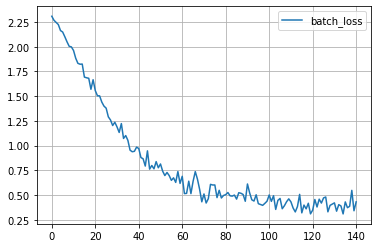

In [ ]:
plt.plot(trainer.callbacks[0].losses, linestyle='-', label="batch_loss")

#plt.semilogy()
plt.legend()
plt.grid()
plt.show() 

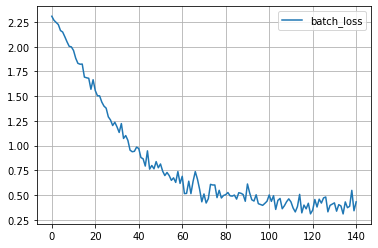

### Profiler 

In [ ]:
model = Model()

trainer = pl.Trainer(max_epochs=3, accelerator='auto', profiler="simple") 
trainer.fit(model, trainDataLoader, val_dataloaders=valDataLoader) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | linear1 | Linear  | 25.1 K
2 | linear2 | Linear  | 25.1 K
3 | linear3 | Linear  | 650   
4 | relu    | ReLU    | 0     
------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

FIT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                                    	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                       

In [ ]:
model = Model()

trainer = pl.Trainer(max_epochs=1, accelerator='auto', profiler="advanced") 
trainer.fit(model, trainDataLoader, val_dataloaders=valDataLoader) 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | linear1 | Linear  | 25.1 K
2 | linear2 | Linear  | 25.1 K
3 | linear3 | Linear  | 650   
4 | relu    | ReLU    | 0     
------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

FIT Profiler Report
Profile stats for: [LightningModule]Model.configure_callbacks
         7 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 contextlib.py:116(__exit__)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.next}
        1    0.000    0.000    0.000    0.000 profiler.py:55(profile)
        1    0.000    0.000    0.000    0.000 advanced.py:66(stop)
        1    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 lightning.py:1153(configure_callbacks)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}



Profile stats for: [LightningModule]Model.prepare_data
         7 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.0

### 모델 저장, 복원  

#### torch.save(), torch.load()

In [ ]:
# torch.save로 모델 전체 저장
torch.save(model, './aicamp/model_save.pt')
# torch.load로 모델 전체 불러오기 
new_model2 = torch.load('./aicamp/model_save.pt')
trainer.validate(new_model2, valDataLoader)

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9749000072479248
        val_loss            0.09433899819850922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_acc': 0.9749000072479248, 'val_loss': 0.09433899819850922}]

#### Save hyperparameters

```python
## Save 
class MyLightningModule(pl.LightningModule):
    def __init__(self, learning_rate, another_parameter, *args, **kwargs):
        super().__init__()
        self.save_hyperparameters()

## Load, Check
checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)
print(checkpoint["hyper_parameters"])
# {"learning_rate": the_value, "another_parameter": the_other_value}
```

#### sate_dict()


In [ ]:
# torch.save(model.state_dict())로 모델 파라메터 저장
torch.save(model.state_dict(), './aicamp/model_dict_save.pt')
new_model2 = Model()
# model.load_state_dict()로 파라메터 불러오기
new_model2.load_state_dict(torch.load('./aicamp/model_dict_save.pt'))
trainer.validate(new_model2, valDataLoader) 

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9749000072479248
        val_loss            0.09433899819850922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_acc': 0.9749000072479248, 'val_loss': 0.09433899819850922}]

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor) 
    print(model.state_dict()[param_tensor].size(),'\n')  

linear1.weight
torch.Size([32, 784]) 

linear1.bias
torch.Size([32]) 

linear2.weight
torch.Size([32, 784]) 

linear2.bias
torch.Size([32]) 

linear3.weight
torch.Size([10, 64]) 

linear3.bias
torch.Size([10]) 



In [ ]:
## state_dict 내부 구조 확인 
p(model.state_dict())  

[]:
Type: <class 'collections.OrderedDict'>
Values: OrderedDict([('linear1.weight', tensor([[ 0.0050, -0.0126,  0.0082,  ..., -0.0210, -0.0298, -0.0262],
        [ 0.0035, -0.0179,  0.0259,  ...,  0.0121,  0.0190, -0.0207],
        [-0.0210, -0.0256,  0.0285,  ...,  0.0147, -0.0150, -0.0354],
        ...,
        [-0.0138, -0.0335,  0.0065,  ...,  0.0217, -0.0200, -0.0101],
        [-0.0079, -0.0067,  0.0177,  ...,  0.0141,  0.0357,  0.0260],
        [ 0.0202,  0.0110,  0.0313,  ...,  0.0252, -0.0317, -0.0041]])), ('linear1.bias', tensor([-0.0339, -0.1371, -0.1334,  0.1953,  0.0731, -0.0201,  0.2339,  0.0953,
        -0.1459,  0.0699, -0.0357,  0.0527, -0.0236,  0.0308,  0.0945,  0.0508,
         0.0098, -0.1425,  0.1399,  0.1510,  0.0622, -0.0297,  0.0698,  0.0354,
         0.1415,  0.1468,  0.1006,  0.1116,  0.1137, -0.0566,  0.1230,  0.1276])), ('linear2.weight', tensor([[-0.0348,  0.0024,  0.0105,  ...,  0.0033, -0.0214,  0.0346],
        [ 0.0211,  0.0172, -0.0325,  ...,  0.0217, 

```phthon
Values: OrderedDict([
        ('linear1.weight', tensor(
          [[ 0.0310, -0.0020, -0.0070,  ..., -0.0213,  0.0240, -0.0339],
          [ 0.0210,  0.0066, -0.0263,  ..., -0.0341, -0.0298,  0.0141],
          [-0.0195, -0.0131,  0.0153,  ..., -0.0100, -0.0170,  0.0296],
          ...,
          [-0.0137, -0.0253,  0.0137,  ...,  0.0050, -0.0330,  0.0331],
          [-0.0146,  0.0133,  0.0177,  ..., -0.0294,  0.0008, -0.0220],
          [ 0.0291, -0.0138,  0.0301,  ...,  0.0352,  0.0098, -0.0098]])),
        ('linear1.bias', tensor(
          [-0.1586, -0.1492,  0.0181,  0.0326, -0.0617, -0.0147, -0.1302,  0.1725,
          -0.1188,  0.0836,  0.2370, -0.0967,  0.3065,  0.3255, -0.0194,  0.0121,
          -0.0326,  0.0574, -0.1692,  0.3240,  0.3213,  0.1743, -0.1154,  0.0147,
          -0.0202,  0.0855,  0.0736,  0.1041, -0.0128,  0.2063,  0.1225,  0.1850])),
        ('linear2.weight', tensor(
          [[ 1.3412e-03,  1.8246e-02,  2.5799e-02,  ..., -2.2528e-02,
          5.9206e-03,  2.1104e-02]],...))])
```          

### Device Handling

In [ ]:
## Multi-GPU Training
trainer = pl.Trainer(gpus=8, distributed_backend='dp')

## TPU Training 
trainer = pl.Trainer(tpu_cores=[5])

## FP16 Training
trainer = pl.Trainer(precision=16)


# LightningModule, Training class Summary  

## Methods 

Method name| Description
--|--
init|Define computations here
forward|Use for inference only (separate from training_step)
training_step|the complete training loop
validation_step|the complete validation loop
test_step|the complete test loop
predict_step|the complete prediction loop
configure_optimizers|define optimizers and LR schedulers


Method name| Description
--|--
init|Customize every aspect of training via flags.
fit|Runs the full optimization routine.
validate|Perform one evaluation epoch over the validation set.
test|Perform one evaluation epoch over the test set.
tune|Runs routines to tune hyperparameters before training.

* tune() :  https://pytorch-lightning.readthedocs.io/en/1.4.0/advanced/lr_finder.html 

```python
class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 10)
    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
```

```python
model = LitModel()
trainer = pl.Trainer(flags)
trainer.fit(model, trainDataLoader, valDataLoader)
trainer.validate(dataloaders=valDataLoader)
trainer.test(dataloaders=valDataLoader)
```

## Trainer flags

```python 
trainer = pl.Trainer(flags)
flags : 
max_epochs=1000
min_epochs=1
max_steps=100
accelerator="auto"        # CPU,GPU,TPU,auto
deterministic=True        # reproducibility 
callbacks=[Callback()]
check_val_every_n_epoch=1 #  
gradient_clip_val=0.0 
limit_train_batches=0.25  # 25% training / epoch
limit_test_batches=0.25
limit_val_batches=0.25
log_every_n_steps=50
logger=logger 
max_time="00:12:00:00"
overfit_batches=10        # 0.01(1%)
precision=32         
enable_progress_bar=True
weights_summary="top"     # full,None  
enable_model_summary=True

```